In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import time
import json
import os

In [2]:
def DataAggregator(path):
    text_dict = {}
    json_dict = {}
    label_df = pd.DataFrame(columns=['changes', 'positions','file'])

    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(path+file, 'r', encoding='utf-8') as myfile:
                text_dict[file.replace('problem-', '').replace('.txt', '')] = myfile.read().replace('\n', '')
        else:
            with open(path+file, 'r', encoding='utf-8') as myfile:
                data = json.load(myfile)
                json_dict[file.replace('problem-', '').replace('.truth', '')] = data['changes']

    df = pd.DataFrame(list(text_dict.items()), columns=['file', 'text'])
    label_df = pd.DataFrame(list(json_dict.items()), columns = ['file', 'changes'])

    output_df = df.merge(label_df,on='file')
    output_df = output_df.drop('file', axis = 1)
    return output_df

In [3]:
#Convert the data sets to data frames
test_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-test-dataset-2018-01-31/')
training_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-training-dataset-2018-01-31/')
validation_df = DataAggregator('C:/Users/RSC/PyProjects/Data-Science/Data/pan18-style-change-detection-validation-dataset-2018-01-31/')


In [4]:
#Split the data into text and labels
training_labels = training_df['changes']
validation_labels = validation_df['changes']
test_labels = test_df['changes']

training_text = list(training_df['text'])
validation_text = list(validation_df['text'])
test_text = list(test_df['text'])

print("Training Text: " + str(len(training_text)) + ", Training Labels: " + str(len(training_labels)))
print("Test Text: " + str(len(test_text)) + ", Test Labels: " + str(len(test_labels)))
print("Validation Text: " + str(len(validation_text)) + ", Validation Labels: " + str(len(validation_labels)))

Training Text: 2980, Training Labels: 2980
Test Text: 1352, Test Labels: 1352
Validation Text: 1492, Validation Labels: 1492


In [5]:
#Builds a pipeline
NB_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                         ('tfidf', TfidfTransformer()),
                         ('clf', BernoulliNB())])

SVC_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                        ('tfidf', TfidfTransformer()),
                        ('clf', SVC(C=0.5, probability=True))])

KNN_pipeline = Pipeline([('vect', CountVectorizer(strip_accents = 'ascii', ngram_range=(1,5), analyzer='word', stop_words='english')),
                        ('tfidf', TfidfTransformer()),
                        ('clf', KNeighborsClassifier(20))])

In [6]:
'''
#Find best parameters
parameters = {'vect__ngram_range': [(1,5)],
              'tfidf__use_idf': (True, False),
              'clf__C':[0.5,1.0,2.0,5.0]}

#nb_search = GridSearchCV(NB_pipeline, parameters, n_jobs=-1)
#nb_search = nb_search.fit(training_text, training_labels)

svc_search = GridSearchCV(SVC_pipeline, parameters, n_jobs=-1)
svc_search = svc_search.fit(training_text, training_labels)

print("Best NB Score: " + str(nb_search.best_score_) + " -- Best NB Params: " + str(nb_search.best_params_))
print("Best SVC Score: " + str(svc_search.best_score_) + " -- Best SVC Params: " + str(svc_search.best_params_))
'''

'\n#Find best parameters\nparameters = {\'vect__ngram_range\': [(1,5)],\n              \'tfidf__use_idf\': (True, False),\n              \'clf__C\':[0.5,1.0,2.0,5.0]}\n\n#nb_search = GridSearchCV(NB_pipeline, parameters, n_jobs=-1)\n#nb_search = nb_search.fit(training_text, training_labels)\n\nsvc_search = GridSearchCV(SVC_pipeline, parameters, n_jobs=-1)\nsvc_search = svc_search.fit(training_text, training_labels)\n\nprint("Best NB Score: " + str(nb_search.best_score_) + " -- Best NB Params: " + str(nb_search.best_params_))\nprint("Best SVC Score: " + str(svc_search.best_score_) + " -- Best SVC Params: " + str(svc_search.best_params_))\n'

In [7]:
#Train the models and fit to the validation set
start = time.time()
NB_pipeline.fit(training_text, training_labels)
nb_prediction = NB_pipeline.predict(validation_text)
print("Naive Bayes Accuracy: " + str(metrics.accuracy_score(nb_prediction, validation_labels)) + " -- Run time " + str(time.time()-start))
nb_confusion = metrics.confusion_matrix(nb_prediction, validation_labels)
print(nb_confusion)


start = time.time()
SVC_pipeline.fit(training_text, training_labels)
svc_prediction = SVC_pipeline.predict(validation_text)
print("SVM Accuracy: " + str(metrics.accuracy_score(svc_prediction, validation_labels)) + " -- Run time " + str(time.time()-start))
svc_confusion = metrics.confusion_matrix(svc_prediction, validation_labels)
print(svc_confusion)

start = time.time()
KNN_pipeline.fit(training_text, training_labels)
knn_prediction = KNN_pipeline.predict(validation_text)
print("KNN Accuracy: " + str(metrics.accuracy_score(knn_prediction, validation_labels)) + " -- Run time " + str(time.time()-start))
knn_confusion = metrics.confusion_matrix(knn_prediction, validation_labels)
print(knn_confusion)

Naive Bayes Accuracy: 0.881367292225 -- Run time 74.57573342323303
[[695 126]
 [ 51 620]]
SVM Accuracy: 0.658847184987 -- Run time 549.5619184970856
[[592 355]
 [154 391]]
KNN Accuracy: 0.563002680965 -- Run time 38.25373101234436
[[289 195]
 [457 551]]


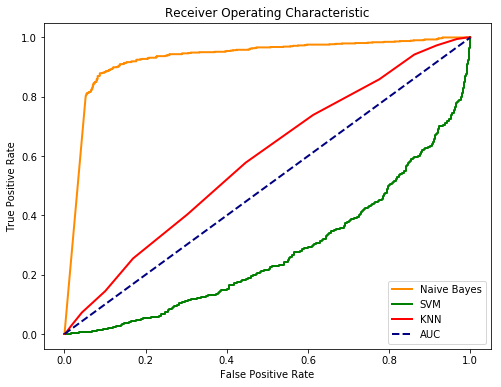

In [8]:
fpr = dict()
tpr = dict()
roc_auc = dict()

nb_fpr, nb_tpr, _ = metrics.roc_curve(validation_labels, NB_pipeline.predict_proba(validation_text)[:,1])
svc_fpr, svc_tpr, _ = metrics.roc_curve(validation_labels, SVC_pipeline.predict_proba(validation_text)[:,1])
knn_fpr, knn_tpr, _ = metrics.roc_curve(validation_labels, KNN_pipeline.predict_proba(validation_text)[:,1])

fig, ax = plt.subplots(sharey=True, figsize=(8,6))
ax.plot(nb_fpr, nb_tpr, color='darkorange', lw=2, label='ROC curve')
ax.plot(svc_fpr, svc_tpr, color='green', lw=2, label='ROC curve')
ax.plot(knn_fpr, knn_tpr, color='red', lw=2, label='ROC curve')
ax.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(['Naive Bayes', 'SVM', 'KNN', 'AUC'],loc="lower right")
plt.show()